# Project: No-show appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
 - ‘ScheduledDay’ tells us on what day the patient set up their appointment.
 - ‘Neighborhood’ indicates the location of the hospital.
 - ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
 - Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In [57]:
df = pd.read_csv('./data/noshowappointments.csv')
df.tail(n=2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


### Types of data inside the dataframe

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Size of the original dataframe

In [41]:
df.shape

(110527, 14)

### Number of unique area in the dataframe

In [42]:
df['Neighbourhood'].unique().size

81

## Conjecture: 
**If the waiting time is higher people tend to miss their appointment.**

In order to get meaningful data to verify this conjecture we need to add a new column with the waiting time to get an appointment in the dataframe.

** One important thing to notice: If it is a same day appointment the wait time calculation gives negative ouput, which is not possible. Those values are replaced by 0.**

In [58]:
appointment_time_stamp = pd.to_datetime(df['AppointmentDay'])
scheduled_time_stamp = pd.to_datetime(df['ScheduledDay'])
wait_time = appointment_time_stamp - scheduled_time_stamp

wait_hour = []
for time in wait_time:
    h = np.timedelta64(time)/np.timedelta64(1, 'h')
    if h >=0:
        wait_hour.append(h/24)
    else:
        wait_hour.append(0)
        
noshow = []
for item in df['No-show']:
    if item == 'No':
        noshow.append(1)
    elif item == 'Yes':
        noshow.append(1)

In [59]:
df = df.assign(wait_time = wait_hour, Noshow_num = noshow)

### Drop unnecessary columns from the dataframe

In [60]:
drop_col = ['PatientId', 'AppointmentID', 'ScheduledDay','AppointmentDay']
df.drop(labels = drop_col, axis = 1, inplace = True)

In [61]:
df.tail(n = 2)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Noshow_num,wait_time
110525,F,38,MARIA ORTIZ,0,0,0,0,0,1,No,1,40.368484
110526,F,54,MARIA ORTIZ,0,0,0,0,0,1,No,1,40.436852


### Save cleaned data into a csv file

In [62]:
df.to_csv('./data/cleaned-appointment-data.csv', index = False)

<a id='eda'></a>
## Exploratory Data Analysis

## Q1. What is the average no-show patient age for different genders?

**Answer: **
 - From the barplot below average age of female patients is higher than male patients.
 - The violinplot suggests that there are more male patients at younger age than female patients, who failed to come to their appointments.

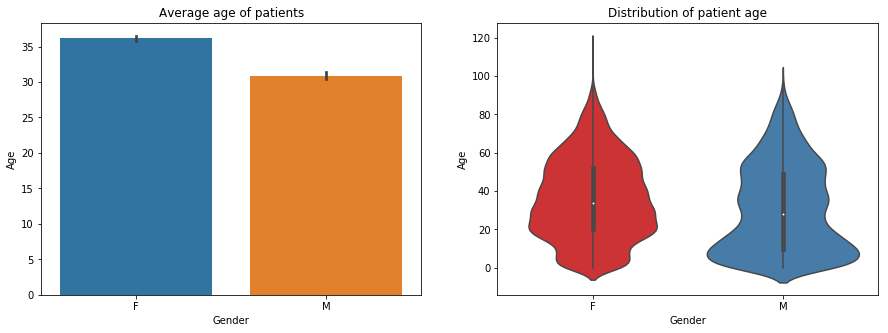

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x='Gender',y='Age',data=df[df['No-show']=='Yes']).set_title('Average age of patients');
plt.subplot(1,2,2)
sns.violinplot(x = 'Gender', y="Age", data=df[df['No-show']=='Yes'], scale = 'area', palette='Set1').set_title('Distribution of patient age');

** There are more female appointment than male ones. **

Therefore it is sometime wise to draw statistical inference in terms of ratio instead of actual numbers.

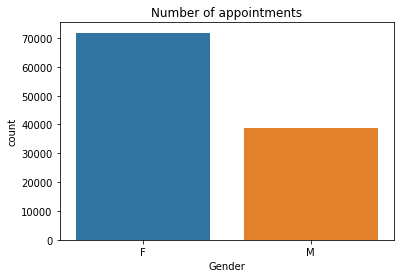

In [20]:
sns.countplot(x = 'Gender', data = df).set_title('Number of appointments');

## Q2. Which factors are relevant for no show?
 - **Answer: ** From the countplots below it seems like people, who do not recive SMS about their appointment are highly likely to not show up. But it is inconclusive because the number distribution is unclear from this kind of countplot.

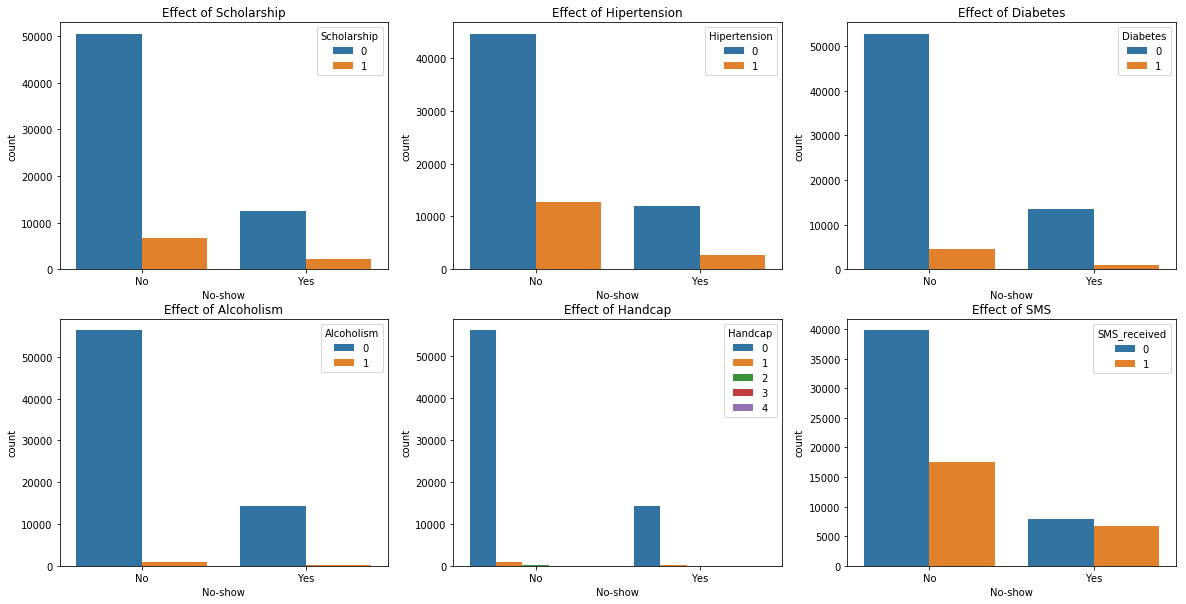

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(2, 3, 1)
sns.countplot(x = 'No-show', hue = 'Scholarship', data = df[df['Gender'] == 'F']).set_title('Effect of Scholarship');
plt.subplot(2, 3, 2)
sns.countplot(x = 'No-show', hue = 'Hipertension', data = df[df['Gender'] == 'F']).set_title('Effect of Hipertension');
plt.subplot(2, 3, 3)
sns.countplot(x = 'No-show', hue = 'Diabetes', data = df[df['Gender'] == 'F']).set_title('Effect of Diabetes');
plt.subplot(2, 3, 4)
sns.countplot(x = 'No-show', hue = 'Alcoholism', data = df[df['Gender'] == 'F']).set_title('Effect of Alcoholism');
plt.subplot(2, 3, 5)
sns.countplot(x = 'No-show', hue = 'Handcap', data = df[df['Gender'] == 'F']).set_title('Effect of Handcap');
plt.subplot(2, 3, 6)
sns.countplot(x = 'No-show', hue = 'SMS_received', data = df[df['Gender'] == 'F']).set_title('Effect of SMS');


## Observation:

The countplot shown above displays relational statistics for single feature. It could be true that a combination of features has more relation with the no-show appointments. To figure that out we can create a pivot table for all available features with no-show count.

** For simplicity we are ignoring 'Handcap' feature, because it has more than 2 possible unique values.**

In [89]:
pivot_cols = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']
pivot_df = pd.pivot_table(df, values = 'Noshow_num', index = 'No-show', columns = pivot_cols, aggfunc=np.sum)

In [90]:
pivot_df

Scholarship         0                                                    \
Hipertension        0                                                     
Diabetes            0                              1                      
Alcoholism          0                1             0            1         
SMS_received        0        1       0      1      0      1     0     1   
No-show                                                                   
No            43083.0  17918.0  1075.0  268.0  740.0  274.0  40.0  10.0   
Yes            8794.0   6984.0   181.0  128.0  148.0   96.0   7.0   3.0   

Scholarship                  ...      1                                  \
Hipertension       1         ...      0           1                       
Diabetes           0         ...      1           0                       
Alcoholism         0         ...      1           0             1         
SMS_received       0       1 ...      0    1      0      1      0     1   
No-show                      ...                                          
No            7467.0  3333.0 ...   11.0  2.0  709.0  302.0  139.0  20.0   
Yes           1251.0   926.0 ...    3.0  NaN  146.0  110.0   21.0   7.0   

Scholarship                           
Hipertension                          
Diabetes          1                   
Alcoholism        0           1       
SMS_received      0     1     0    1  
No-show                               
No            236.0  93.0  10.0  3.0  
Yes            45.0  36.0   4.0  3.0  

[2 rows x 32 columns]

## In order for better visualization log of the count is plotted below.

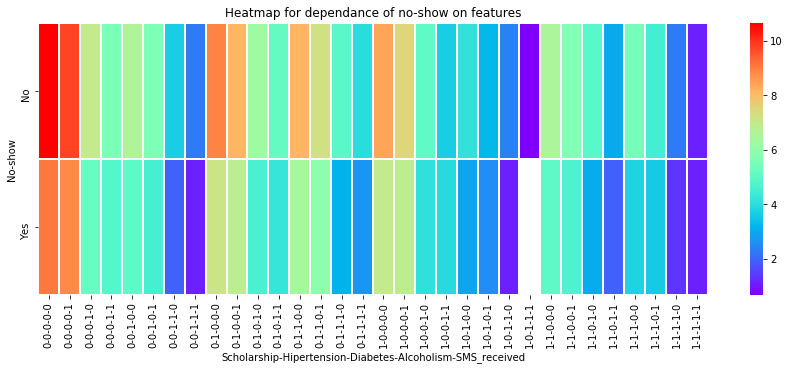

In [91]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(np.log(pivot_df), cmap = 'rainbow', linewidth = 1).set_title('Heatmap for dependance of no-show on features');

## Observation from heatmap: 

### features = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']

 - Fromt the heatmap above we can tell those who has no feature characteristics are likely to not show up for their appointment. This number is more than people who have received SMS for their appointment.
 - There is a higher chance of no show if the patient has hipertension.
 - If a patient has scholarship, he or she is less likely to not show up for their appointment.

### Create a dataframe with only no-show patients:

In [14]:
dfn = df[df['No-show'] == 'Yes']
dfn['Age'].count()

22319

## Calculate the patient ratio for different features in the dataset:

 - **Answer: ** From the barplot below, Alcoholism has the highest dependence with the no-show patients.

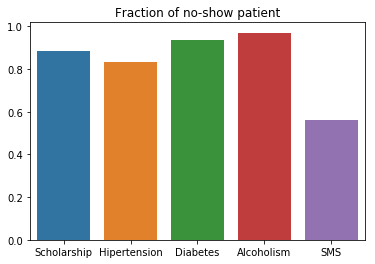

In [25]:
No_Scholarship = dfn[dfn['Scholarship'] == 0]['Age'].count() / dfn['Age'].count()
No_Hipertension = dfn[dfn['Hipertension'] == 0]['Age'].count() / dfn['Age'].count()
No_Diabetes = dfn[dfn['Diabetes'] == 0]['Age'].count() / dfn['Age'].count()
No_Alcoholism = dfn[dfn['Alcoholism'] == 0]['Age'].count() / dfn['Age'].count()
No_Handcap = dfn['Handcap'].value_counts() / dfn['Age'].count()
No_SMS = dfn[dfn['SMS_received'] == 0]['Age'].count() / dfn['Age'].count()

no_ratios = [No_Scholarship, No_Hipertension, No_Diabetes, No_Alcoholism, No_SMS]
sns.barplot(x = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS'], y = no_ratios).set_title('Fraction of no-show patient');

## Dependence of no-show on 'Handcap' is inconclusive from the barplot below.

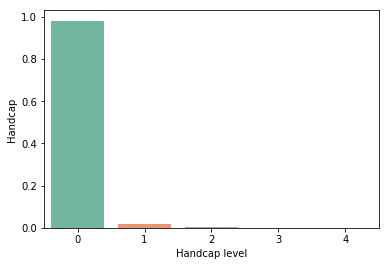

In [37]:
bp1 = sns.barplot(x = [0,1,2,3,4], y = No_Handcap, palette = 'Set2').set_title('');
bp1.set_xlabel('Handcap level');

## Q3. Is it true that more people do not show up if their waiting time is longer?
 - **Answer: ** This is indeed true as we can see in the violinplot below. If waiting time becomes more than couple of hours there are more number of people who might not show up for the appointment time. It is true for both genders.

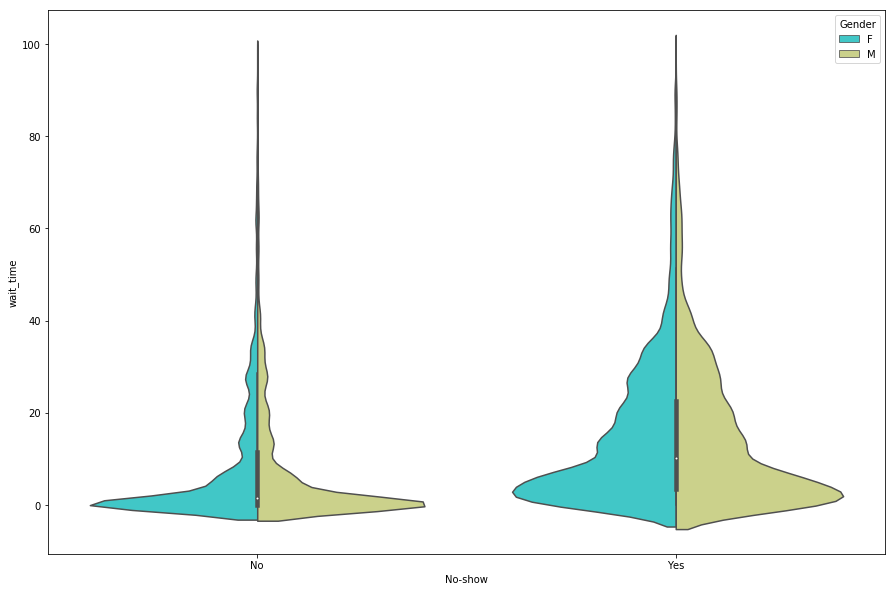

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(x = 'No-show', y = 'wait_time', hue = 'Gender', data = df[df['wait_time']<100], split = True, scale = 'area', palette='rainbow');

## Limitation of the data:

 - Most of the features in the dataset are 2-valued features. Therefore finding correlation between those features and no-show appointment is not possible. 

<a id='conclusions'></a>
## Conclusions

 - Even though simple data analysis gave us some insight on whether a patient will show up for the appointment or not, training a  machine for classification might have been more helpful for this particular data set.
 - In future I would further like to explore this dataset for its dependence on location and age.